In [39]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from config import TARGET, ID_COL, COHORT_COL, RANDOM_STATE
from features import get_features_for_cohort
from utils import save_model

In [40]:
DATA_PATH = Path("../data/gold/gold_data.csv")
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1576, 20)


,RA,IAA,IEG,IPS,math,portuguese,has_lag,IAA__minus_1,IEG__minus_1,IPS__minus_1,math__minus_1,portuguese__minus_1,has_lag__minus_1,IAA__minus_2,IEG__minus_2,IPS__minus_2,math__minus_2,portuguese__minus_2,has_lag__minus_2,years
0,RA-1,8.3,4.1,5.6,2.7,3.5,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,RA-2,8.8,5.2,6.3,6.3,4.5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,RA-3,0.0,7.9,5.6,5.8,4.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,RA-4,8.8,4.5,5.6,2.8,3.5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,RA-5,7.9,8.6,5.6,7.0,2.9,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [41]:
def get_models():
    return {
        "LogisticRegression": Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                random_state=RANDOM_STATE
            ))
        ]),

        "RandomForest": Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("model", RandomForestClassifier(
                n_estimators=300,
                max_depth=6,
                class_weight="balanced",
                random_state=RANDOM_STATE,
                n_jobs=-1
            ))
        ]),

        "LightGBM": lgb.LGBMClassifier(
            n_estimators=600,
            learning_rate=0.05,
            class_weight="balanced",
            random_state=RANDOM_STATE
        )
    }

In [42]:
def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    return scores.mean(), scores.std()

In [ ]:
results = []

for cohort in [1, 2, 3]:

    df_c = df[df[COHORT_COL] == cohort].copy()

    if len(df_c) < 30:
        continue

    features = get_features_for_cohort(df_c, cohort)
    X = df_c[features]
    y = df_c[TARGET]

    print(f"\n🚀 Cohort {cohort}")

    models = get_models()

    best_auc = 0
    best_model = None
    best_name = None

    for name, model in models.items():
        mean_auc, std_auc = evaluate_model(model, X, y)
        print(f"{name}: {mean_auc:.4f} ± {std_auc:.4f}")

        results.append({
            "strategy": "cohort",
            "cohort": cohort,
            "model": name,
            "auc": mean_auc
        })

        if mean_auc > best_auc:
            best_auc = mean_auc
            best_model = model
            best_name = name

    # Fit best model on full cohort data
    best_model.fit(X, y)
    save_model(best_model, f"cohort_{cohort}", "models")

    print(f"🏆 Best model saved: cohort_{cohort}_{best_name}")


🚀 Cohort 1
LogisticRegression: 0.5375 ± 0.0245
RandomForest: 0.5949 ± 0.0256
[LightGBM] [Info] Number of positive: 392, number of negative: 209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values("auc", ascending=False)

,strategy,cohort,model,auc
7,cohort,3,RandomForest,0.766315
8,cohort,3,LightGBM,0.752378
6,cohort,3,LogisticRegression,0.732826
3,cohort,2,LogisticRegression,0.643452
4,cohort,2,RandomForest,0.639435
5,cohort,2,LightGBM,0.627679
1,cohort,1,RandomForest,0.594867
2,cohort,1,LightGBM,0.559946
0,cohort,1,LogisticRegression,0.537512


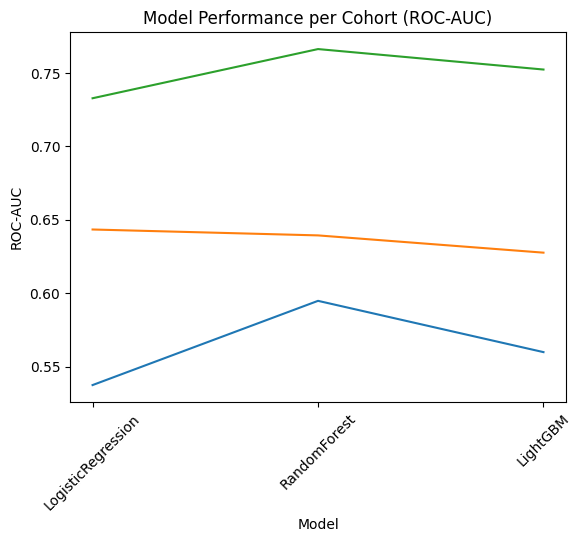

In [ ]:
cohort_results = results_df[results_df["strategy"] == "cohort"]

plt.figure()

for cohort in sorted(cohort_results["cohort"].unique()):
    subset = cohort_results[cohort_results["cohort"] == cohort]
    plt.plot(subset["model"], subset["auc"])

plt.title("Model Performance per Cohort (ROC-AUC)")
plt.xlabel("Model")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=45)
plt.show()

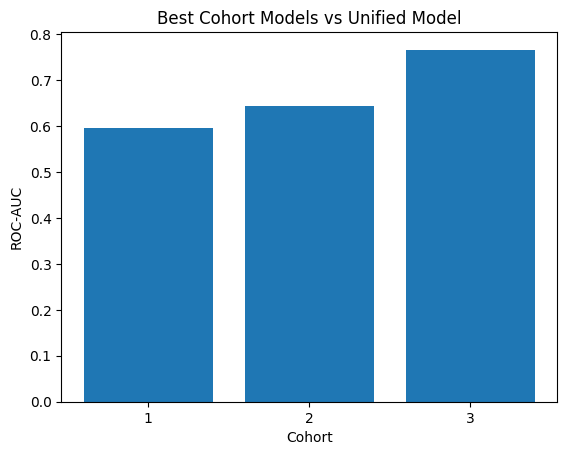

In [ ]:
best_per_cohort = (
    cohort_results
    .sort_values("auc", ascending=False)
    .groupby("cohort")
    .first()
    .reset_index()
)

comparison_df = pd.concat([
    best_per_cohort,
    results_df[results_df["strategy"] == "unified"]
])

plt.figure()
plt.bar(comparison_df["cohort"].astype(str), comparison_df["auc"])
plt.title("Best Cohort Models vs Unified Model")
plt.xlabel("Cohort")
plt.ylabel("ROC-AUC")
plt.show()